# SETTINGS

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import copy
from script import *
from app_1 import *

In [2]:
BATCH_SIZE = 32
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Applying Augmentation APP1 and visualizing samples

len train:  957
len val:  239
len test:  75


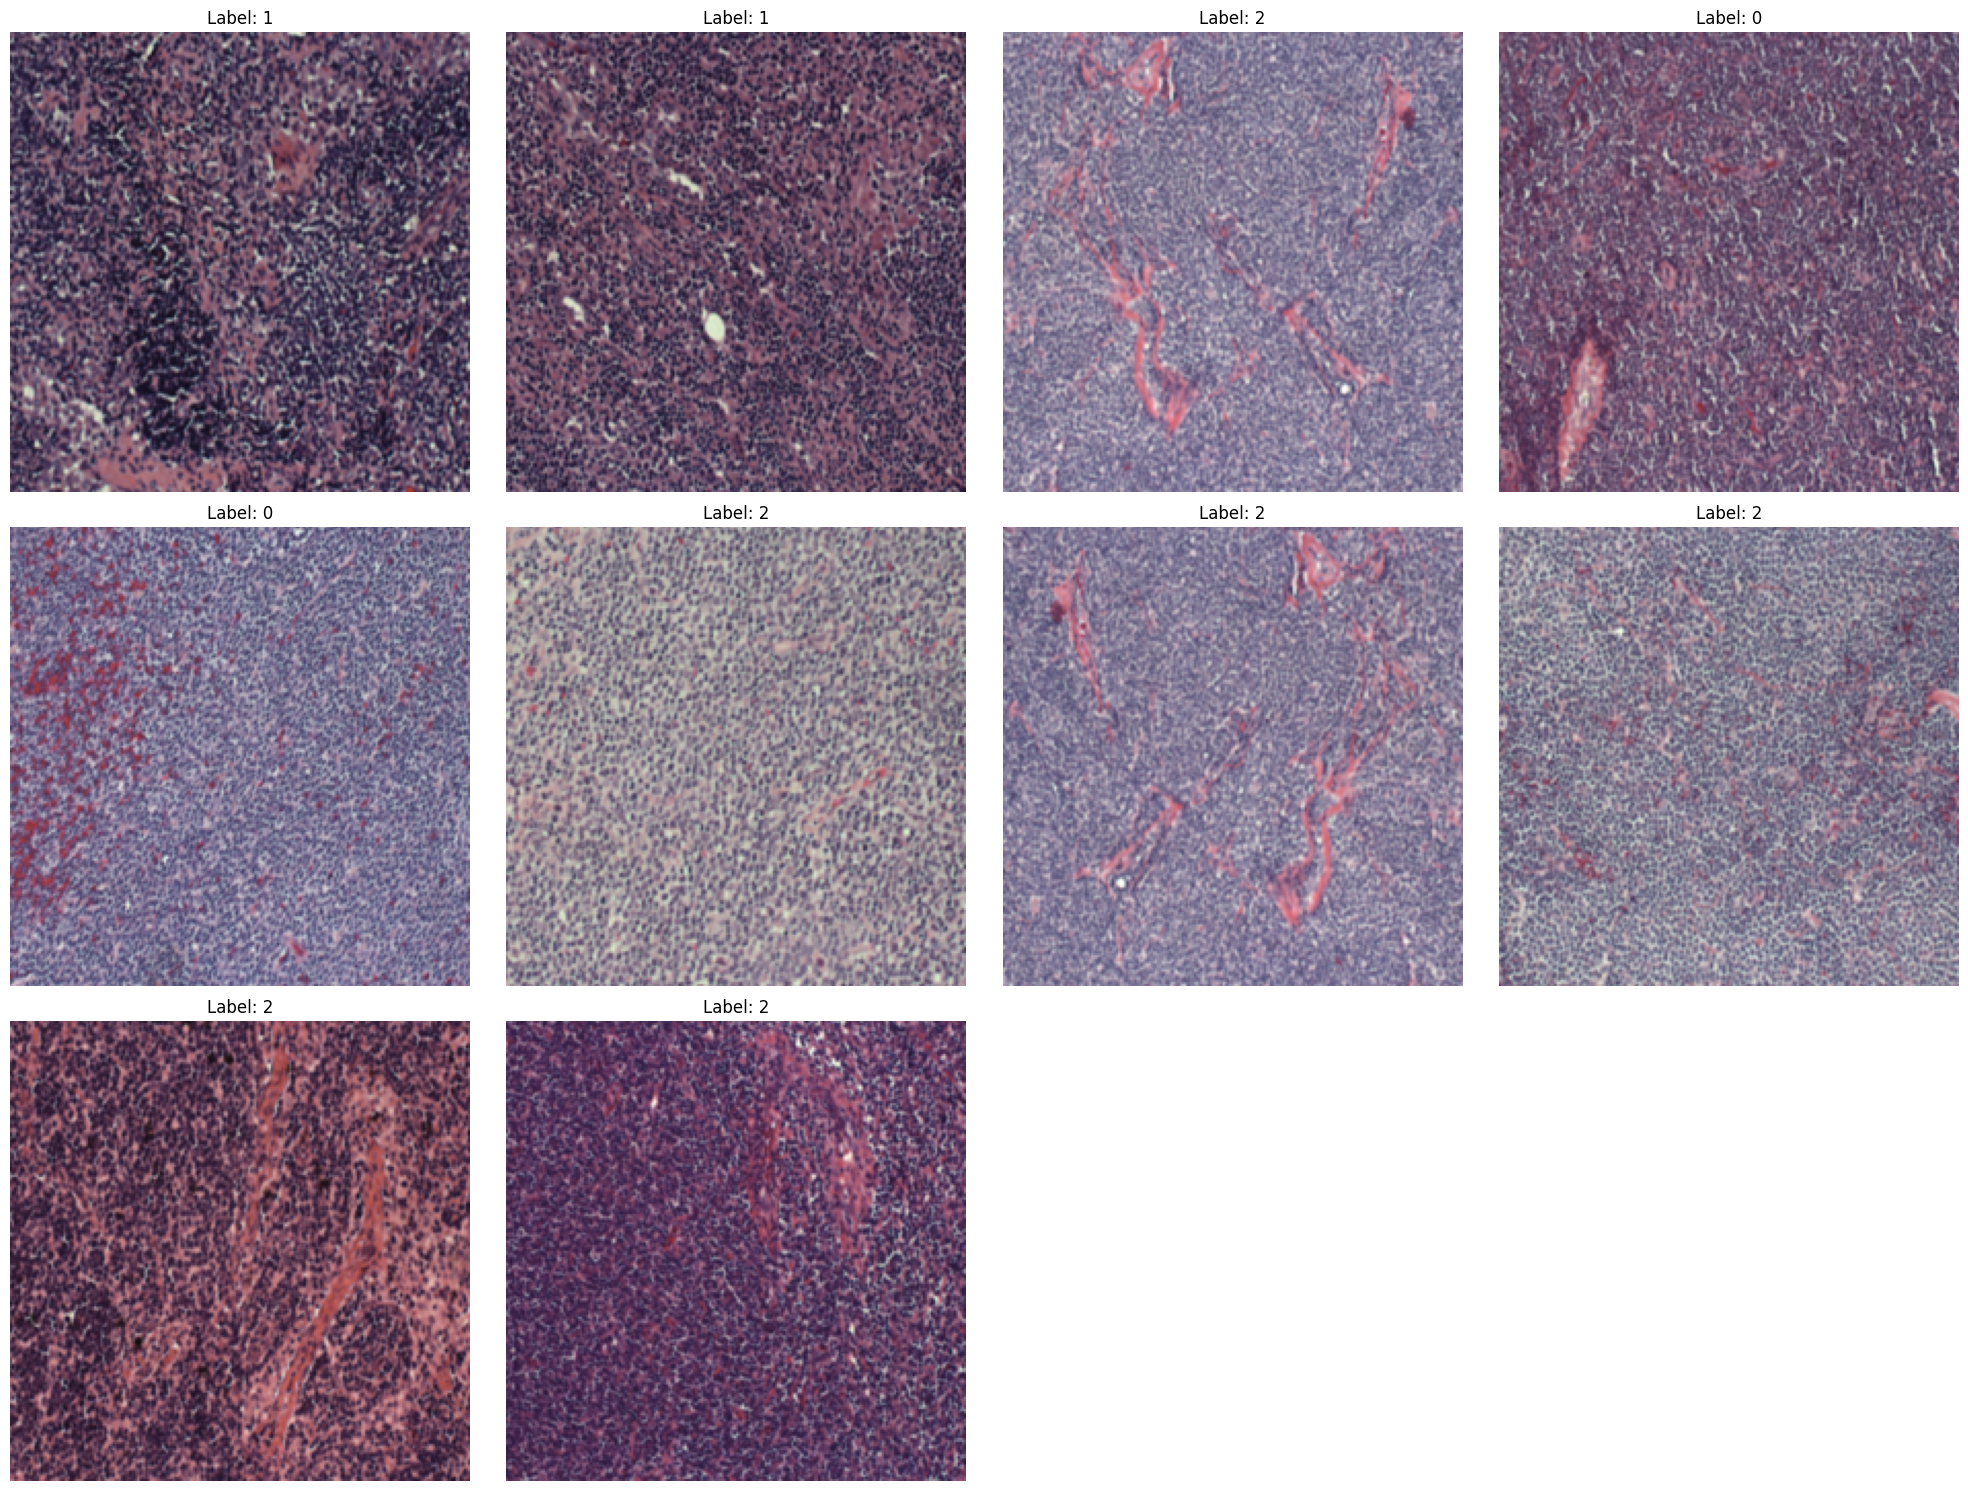

In [3]:
dm = MyDataModule(batch_size=BATCH_SIZE, transform=APP1.APP1, augment=True)
dm.setup()
train = dm.train_dataloader()
test = dm.test_dataloader()
val = dm.val_dataloader()

num_images = 10  
images_per_row = 4  

for inputs, labels in train:
    num_rows = (num_images + images_per_row - 1) / images_per_row 
    num_rows = int(num_rows) 

    plt.figure(figsize=(images_per_row * 5, num_rows * 5))  

    for idx in range(num_images):
        plt.subplot(num_rows, images_per_row, idx + 1) 
        plt.imshow(inputs[idx].permute(1, 2, 0).cpu().numpy()) 
        plt.axis('off')
        plt.title(f"Label: {labels[idx]}")  

    plt.tight_layout() 
    plt.show() 
    break  


# Custom EarlyStopping


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, best_model_weights = None, best_loss = float('inf')):
        self.patience = patience
        self.best_model_weights = best_model_weights
        self.best_loss = best_loss

    def early_stopping(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_weights = copy.deepcopy(model.state_dict())  
            self.patience = 10  # Reset patience counter
            return True

        else:
            self.patience -= 1
            print("Patience:", self.patience)
            if self.patience == 0:
                print("Stopped!")
                return False
        
            return True
    def save_best_model(self, save_path):
        if self.best_model_weights is not None:
            torch.save(self.best_model_weights, save_path)
            print(f"Best model weights saved to {save_path}")
        else:
            print("No best model weights to save.")


# First Model: AlexNet

In [5]:
Alexnet_model = torchvision.models.alexnet(weights='DEFAULT')
Alexnet_model.classifier[4] = nn.Linear(4096,1024)

Alexnet_model.classifier[6] = nn.Linear(1024,3)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 146MB/s]  


In [6]:

Alexnet_model = Alexnet_model.to(DEVICE)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Alexnet_model.parameters(), lr=0.0001)
# Lists to store loss and accuracy values
loss_values = []
accuracy_values = []
val_losses = []
val_accuracies = []
best_model_weights = None
es = EarlyStopping(patience = 10, best_model_weights = None, best_loss = float('inf'))

# Training loop
for epoch in range(NUM_EPOCHS): 
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    Alexnet_model.train()
    for inputs, labels in train:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = Alexnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train.dataset)
    epoch_accuracy = 100 * (correct_predictions / total_samples)

    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)
    
    
    # Validation phase
    Alexnet_model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    

    with torch.no_grad():
        for inputs, labels in val:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
         
            outputs = Alexnet_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    val_loss = running_loss / len(val.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * (correct_predictions / total_samples)
    val_accuracies.append(val_accuracy)


    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train loss: {epoch_loss},--- Validation loss: {val_loss}")
    print(f'Train Accuracy: {epoch_accuracy:.2f}%,--- Val Accuracy: {val_accuracy:.2f}%')


    if epoch > 20:
        if not es.early_stopping(val_loss, Alexnet_model):
            best_model_weights = es.best_model_weights
            break
    
    print('--------------------------')

    print()
    print()


es.save_best_model('/kaggle/working/AlexNet_APP1.pth')

print('Finished Training')

Epoch [1/100] - Train loss: 1.03257699053863,--- Validation loss: 0.8342134002362335
Train Accuracy: 44.62%,--- Val Accuracy: 59.41%
--------------------------


Epoch [2/100] - Train loss: 0.8139313677386181,--- Validation loss: 0.7153275975622393
Train Accuracy: 59.14%,--- Val Accuracy: 62.34%
--------------------------


Epoch [3/100] - Train loss: 0.6463385025660197,--- Validation loss: 0.6028716157669801
Train Accuracy: 69.59%,--- Val Accuracy: 70.29%
--------------------------


Epoch [4/100] - Train loss: 0.5544559211940228,--- Validation loss: 0.5050517254544102
Train Accuracy: 74.92%,--- Val Accuracy: 76.99%
--------------------------


Epoch [5/100] - Train loss: 0.38464927707595387,--- Validation loss: 0.3364799708502063
Train Accuracy: 83.59%,--- Val Accuracy: 84.94%
--------------------------


Epoch [6/100] - Train loss: 0.30766928703558233,--- Validation loss: 0.34662511954123004
Train Accuracy: 88.09%,--- Val Accuracy: 85.77%
--------------------------


Epoch [7/100] -

# AlexNet Train && Validation Losses comparison and AUC

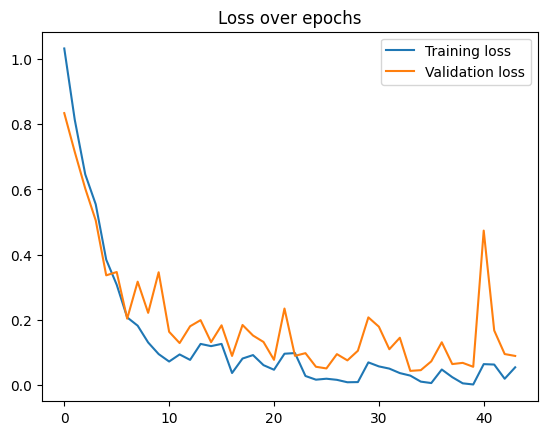

In [7]:
plt.plot(loss_values, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

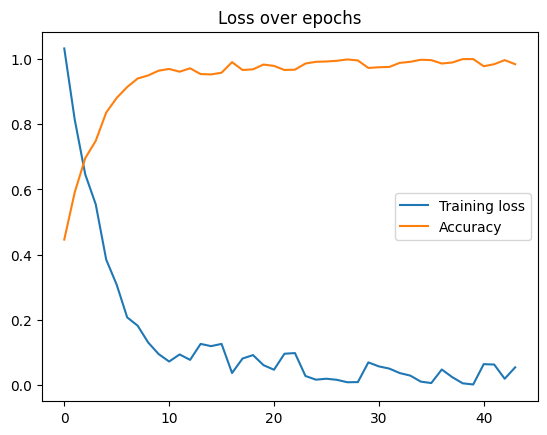

In [8]:
accuracy_values_divided = [value / 100 for value in accuracy_values]

plt.plot(loss_values, label='Training loss')
plt.plot(accuracy_values_divided, label='Accuracy')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# AlexNet Test phase

In [9]:
from sklearn.metrics import classification_report
import itertools

correct = 0
total = 0
predicted_list = []
true_val = []
Alexnet_model.eval()
Alexnet_model.load_state_dict(best_model_weights)

with torch.no_grad():
    for inputs, labels in test:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = Alexnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_list.append(predicted.cpu().numpy())
        true_val.append(labels.cpu().numpy())
        

predicted_list = list(itertools.chain(*predicted_list))
true_val = list(itertools.chain(*true_val))


print(classification_report(true_val, predicted_list))


print(f'Accuracy of the network on the test images: {100 * correct // total} %')

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        29
           1       0.96      0.93      0.94        27
           2       0.93      0.74      0.82        19

    accuracy                           0.91        75
   macro avg       0.92      0.89      0.90        75
weighted avg       0.91      0.91      0.90        75

Accuracy of the network on the test images: 90 %


# Second Model: ResNet-50

In [15]:
resnet50_model = torchvision.models.resnet50(weights='DEFAULT')
resnet50_model.fc = nn.Linear(2048,3)


In [16]:
resnet50_model = resnet50_model.to(DEVICE)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)
# Lists to store loss and accuracy values
loss_values = []
accuracy_values = []
val_losses = []
val_accuracies = []
best_model_weights = None

es = EarlyStopping(patience = 10, best_model_weights = None, best_loss = float('inf'))

for epoch in range(NUM_EPOCHS):  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    resnet50_model.train()
    for inputs, labels in train:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = resnet50_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)  # Assuming 2 classes, which may not be true
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)


    epoch_loss = running_loss / len(train.dataset)
    epoch_accuracy = 100 * (correct_predictions / total_samples)

    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)

    
    
        # Validation phase
    resnet50_model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
         
            outputs = resnet50_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)  # Assuming 2 classes, which may not be true
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    val_loss = running_loss / len(val.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * (correct_predictions / total_samples)
    val_accuracies.append(val_accuracy)


    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train loss: {epoch_loss},--- Validation loss: {val_loss}")
    print(f'Train Accuracy: {epoch_accuracy:.2f}%,--- Val Accuracy: {val_accuracy:.2f}%')


    if epoch > 20:
        if not es.early_stopping(val_loss, resnet50_model):
            best_model_weights = es.best_model_weights
            break
    
    print('--------------------------')

    print()
    print()


es.save_best_model('/kaggle/working/ResNet-50_APP1.pth')



print('Finished Training')

Epoch [1/100] - Train loss: 0.8988400020694035,--- Validation loss: 0.9359656168327172
Train Accuracy: 62.70%,--- Val Accuracy: 62.37%
--------------------------


Epoch [2/100] - Train loss: 0.4043821813606792,--- Validation loss: 0.23448768120929286
Train Accuracy: 90.28%,--- Val Accuracy: 90.55%
--------------------------


Epoch [3/100] - Train loss: 0.1770158572241181,--- Validation loss: 0.10535312150936246
Train Accuracy: 95.61%,--- Val Accuracy: 95.74%
--------------------------


Epoch [4/100] - Train loss: 0.0902981366631317,--- Validation loss: 0.04305357118936014
Train Accuracy: 97.49%,--- Val Accuracy: 97.83%
--------------------------


Epoch [5/100] - Train loss: 0.05266593031919987,--- Validation loss: 0.05183337151879546
Train Accuracy: 98.54%,--- Val Accuracy: 98.58%
--------------------------


Epoch [6/100] - Train loss: 0.07723094833588526,--- Validation loss: 0.04539347924370023
Train Accuracy: 97.49%,--- Val Accuracy: 97.91%
--------------------------


Epoch [7/

# ResNet-50 Train && Validation Losses comparison and AUC

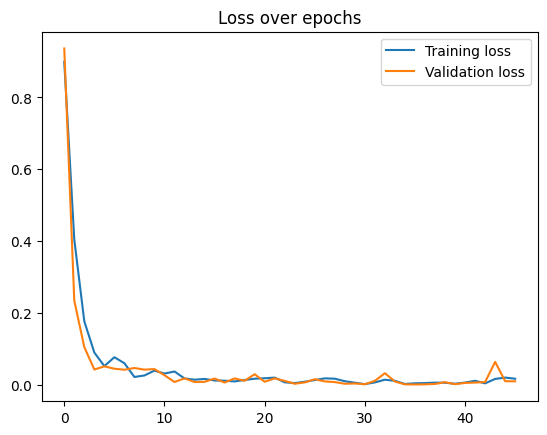

In [17]:
plt.plot(loss_values, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

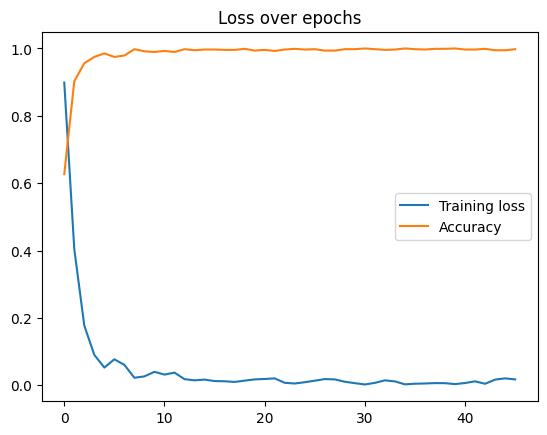

In [18]:
accuracy_values_divided = [value / 100 for value in accuracy_values]

plt.plot(loss_values, label='Training loss')
plt.plot(accuracy_values_divided, label='Accuracy')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Resnet-50 Test Phase

In [19]:
from sklearn.metrics import classification_report
import itertools

correct = 0
total = 0
predicted_list = []
true_val = []
resnet50_model.eval()
resnet50_model.load_state_dict(best_model_weights)

with torch.no_grad():
    for inputs, labels in test:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet50_model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_list.append(predicted.cpu().numpy())
        true_val.append(labels.cpu().numpy())
        
predicted_list = list(itertools.chain(*predicted_list))
true_val = list(itertools.chain(*true_val))

print(classification_report(true_val, predicted_list))

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

              precision    recall  f1-score   support

           0       0.96      0.93      0.95        29
           1       0.89      0.89      0.89        27
           2       0.85      0.89      0.87        19

    accuracy                           0.91        75
   macro avg       0.90      0.90      0.90        75
weighted avg       0.91      0.91      0.91        75

Accuracy of the network on the test images: 90 %


# Third Model: DenseNet-121

In [20]:
densenet121_model = torchvision.models.densenet121(weights='DEFAULT')
densenet121_model.classifier = nn.Linear(1024, 3)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 113MB/s] 


In [21]:
densenet121_model = densenet121_model.to(DEVICE)
best_model_weights = None
es = EarlyStopping(patience = 10, best_model_weights = None, best_loss = float('inf'))


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet121_model.parameters(), lr=0.0001)
# Lists to store loss and accuracy values
loss_values = []
accuracy_values = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS): 
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    densenet121_model.train()
    for inputs, labels in train:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = densenet121_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)  
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)


    epoch_loss = running_loss / len(train.dataset)
    epoch_accuracy = 100 * (correct_predictions / total_samples)

    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)

    
    
    # Validation phase
    densenet121_model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
         
            outputs = densenet121_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    val_loss = running_loss / len(val.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * (correct_predictions / total_samples)
    val_accuracies.append(val_accuracy)


    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train loss: {epoch_loss},--- Validation loss: {val_loss}")
    print(f'Train Accuracy: {epoch_accuracy:.2f}%,--- Val Accuracy: {val_accuracy:.2f}%')


    if epoch > 20:
        if not es.early_stopping(val_loss, densenet121_model):
            best_model_weights = es.best_model_weights
            break
    
    print('--------------------------')

    print()
    print()


es.save_best_model('/kaggle/working/DenseNet-121_APP1.pth')



print('Finished Training')

Epoch [1/100] - Train loss: 0.6166690978199212,--- Validation loss: 0.6375318316734985
Train Accuracy: 75.97%,--- Val Accuracy: 75.17%
--------------------------


Epoch [2/100] - Train loss: 0.17542651869442272,--- Validation loss: 0.12207717411064203
Train Accuracy: 95.72%,--- Val Accuracy: 95.99%
--------------------------


Epoch [3/100] - Train loss: 0.09888877407058902,--- Validation loss: 0.060139010516170675
Train Accuracy: 97.49%,--- Val Accuracy: 97.66%
--------------------------


Epoch [4/100] - Train loss: 0.05251237599601504,--- Validation loss: 0.03405573446630933
Train Accuracy: 99.06%,--- Val Accuracy: 99.16%
--------------------------


Epoch [5/100] - Train loss: 0.05046298885241135,--- Validation loss: 0.028042953734180916
Train Accuracy: 98.54%,--- Val Accuracy: 98.66%
--------------------------


Epoch [6/100] - Train loss: 0.05337373318312186,--- Validation loss: 0.02556935309677942
Train Accuracy: 98.22%,--- Val Accuracy: 98.49%
--------------------------


Epoc

# DenseNet-121 Train && Validation Losses comparison and AUC

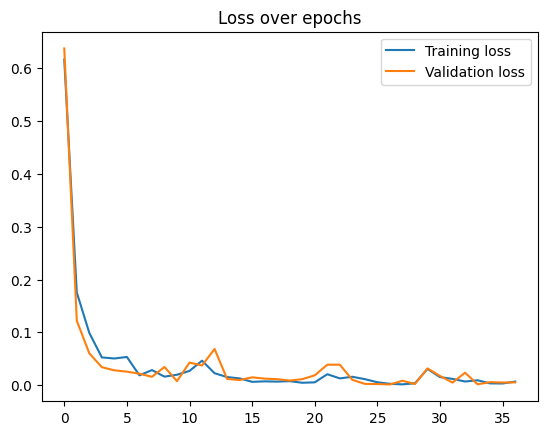

In [22]:
plt.plot(loss_values, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

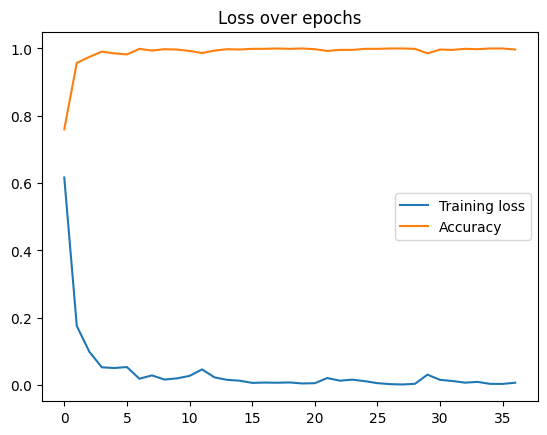

In [23]:
accuracy_values_divided = [value / 100 for value in accuracy_values]

plt.plot(loss_values, label='Training loss')
plt.plot(accuracy_values_divided, label='Accuracy')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import itertools

correct = 0
total = 0
predicted_list = []
true_val = []
densenet121_model.eval()
densenet121_model.load_state_dict(best_model_weights)

with torch.no_grad():
    for inputs, labels in test:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = densenet121_model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_list.append(predicted.cpu().numpy())
        true_val.append(labels.cpu().numpy())

predicted_list = list(itertools.chain(*predicted_list))
true_val = list(itertools.chain(*true_val))

print(classification_report(true_val, predicted_list))

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      0.93      0.96        27
           2       0.90      1.00      0.95        19

    accuracy                           0.97        75
   macro avg       0.97      0.98      0.97        75
weighted avg       0.98      0.97      0.97        75

Accuracy of the network on the test images: 97 %
